In [2]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from astropy import units as u
import scipy.optimize as opt
from photutils import centroids as cent


class PixelMapPeriodogram:
    """Object to hold 2D array of lk.periodgram object data .
    Attributes
    ----------
    targetpixelfile : targetpixelfile object
        
    Optional keywords accepted if ``method='lombscargle'`` are:
            ``minimum_frequency``, ``maximum_frequency``, ``minimum_period``,
            ``maximum_period``, ``frequency``, ``period``, ``nterms``,
            ``nyquist_factor``, ``oversample_factor``, ``freq_unit``,
            ``normalization``, ``ls_method``.
        
    """
    
    def __init__(self, targetpixelfile, gaia=True, magnitude_limit=18, frequencies=[], frequnit=u.Hz ,filter_width =.1, **kwargs):

        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        self.aperture = targetpixelfile.pipeline_mask
        self.tpf = targetpixelfile
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []
        self.freqs_with_filter=[]
        for i in np.arange(0,len(frequencies)):
            for j in np.arange(1,10+1):
                low = 10**(np.log10(frequencies[i])-.5*filter_width/j)
                high = 10**(np.log10(frequencies[i])+.5*filter_width/j)
                self.freqs_with_filter.extend([low,high])
        self.freqs_with_filter.extend(frequencies)
        #self.freqs_with_filter.sort()
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                lc = lc.remove_outliers()
                
                #if method == 'bls':
                    #Making a periodogram for the pixel
                    #periodogram = lc.to_periodogram(method = 'bls')
                    #periodogram.power = periodogram.power / np.median(periodogram.power)
                    #periodogram.power[np.where(periodogram.power<0)] = 0
                    #Extending the list of periodogram data for each pixel
                    #pg.extend([periodogram])
                #Making a periodogram for the pixel
                
                periodogram = lc.to_periodogram(method ='ls', normalization='psd', frequency = self.freqs_with_filter*frequnit, **kwargs)
                #periodogram= periodogram.flatten()
                
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(self.aperture),len(self.aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
        self.timeserieslength = (self.tpf.astropy_time.max()-self.tpf.astropy_time.min()).value
        self.gaiadata = None
        
        if (gaia == True):
            """Make the Gaia Figure Elements"""
            # Get the positions of the Gaia sources
            c1 = SkyCoord(self.tpf.ra, self.tpf.dec, frame='icrs', unit='deg')
            # Use pixel scale for query size
            pix_scale = 4.0  # arcseconds / pixel for Kepler, default
            if self.tpf.mission == 'TESS':
                pix_scale = 21.0
            # We are querying with a diameter as the radius, overfilling by 2x.
            from astroquery.vizier import Vizier
            Vizier.ROW_LIMIT = -1
            result = Vizier.query_region(c1, catalog=["I/345/gaia2"],radius=Angle(np.max(self.tpf.shape[1:]) * pix_scale, "arcsec"))

            no_targets_found_message = ValueError('Either no sources were found in the query region '
                                                      'or Vizier is unavailable')
            too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
            if result is None:
                raise no_targets_found_message
            elif len(result) == 0:
                raise too_few_found_message
            result = result["I/345/gaia2"].to_pandas()

            result = result[result.Gmag < magnitude_limit]
            if len(result) == 0:
                raise no_targets_found_message

            year = ((self.tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
            pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            result.RA_ICRS += pmra
            result.DE_ICRS += pmdec
            radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
            coords = tpf.wcs.all_world2pix(radecs, 0) 



            # Gently size the points by their Gaia magnitude
            sizes = 64.0 / 2**(result['Gmag']/5.0)
            one_over_parallax = 1.0 / (result['Plx']/1000.)
            source = dict(ra=result['RA_ICRS'],
                          dec=result['DE_ICRS'],
                          source=result['Source'].astype(str),
                          Gmag=result['Gmag'],
                          plx=result['Plx'],
                          one_over_plx=one_over_parallax,
                          x=coords[:, 0],
                          y=coords[:, 1],
                          size=sizes)


            self.gaiadata = source
        class frequency_heatmap:

            def __init__(self,tpf,pg,time_series_length,frequencies,frequencies_full,gaia_data):
                heat_stamp = []

                for i in np.arange(0,len(pg)):
                    for j in np.arange(0,len(pg[0])):
                        mask = np.zeros((len(pg),len(pg[0])), dtype=bool)
                        mask[i][j] = True

                        period = pg[mask][0]#.flatten(method='logmedian',filter_width = .1)
                        normperiod = np.asarray(period.power)[21::1]/np.nanmedian(np.asarray(period.power)[0:21])
                        freq = np.asarray(period.frequency)
                        sums = normperiod.sum()*(2*(8/9)**3)
                        
                            #background += len(np.where((freq < frequency_list[k]+(1/(2*time_series_length)) ) & (freq > frequency_list[k]-(1/(2*time_series_length))))[0])#*np.nanmedian(np.asarray(period.power))
                        heat_stamp.extend([sums])

                self.heat_stamp = np.reshape(np.asarray(heat_stamp),(len(pg),len(pg[0])))
                self.gaiadata=gaia_data
            def centroid(self):
                #same sigma, assuming symmetrical distributed psf
                def two_dGaussian( shape , amplitude, xo, yo, sigma):
                    x,y = np.meshgrid(shape[0],shape[1])
                    xo = float(xo)
                    yo = float(yo)    
                    a = 1/(2*sigma**2)
                    g = np.abs(amplitude)*np.exp( - (a*((x-xo)**2) + a*((y-yo)**2)))
                    return g.flatten()

                c = cent.centroid_2dg(self.heat_stamp)
                x = np.arange(0,np.shape(self.heat_stamp)[0])
                y = np.arange(0,np.shape(self.heat_stamp)[1])

                initial_guess = (self.heat_stamp.max(),c[0],c[1],1)
                popt, pcov = opt.curve_fit(two_dGaussian, (x,y),self.heat_stamp.flatten(), p0=initial_guess)

                self.x = popt[1]
                self.y = popt[2]
                self.sigma = popt[3]
                self.covariance=pcov
            def star_list(self):
                gaia_data = self.gaiadata
                no_gaia_data_message = ValueError('No gaia data initialized in PixelMapPeriodogram class')
                if gaia_data ==None :
                    raise no_gaia_data_message

                else:    
                    closest_star_mask = np.where(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])==(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])).min())
                    stars = dict(ra = np.asarray(gaia_data['ra']),
                                 dec = np.asarray(gaia_data['dec']),
                                 source = np.asarray(gaia_data['source']),
                                 x = np.asarray(gaia_data['x']),
                                 y = np.asarray(gaia_data['y']),
                                 distance = np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y']))
                    starlist = pd.DataFrame.from_dict(stars)
                    self.stars = starlist.sort_values(by=[r'distance'])
                    
        fh = frequency_heatmap(self.tpf,self.periodogram,self.timeserieslength,frequencies,self.freqs_with_filter,self.gaiadata) 
        fh.centroid()
        fh.star_list()
        self.centroid = [fh.x,fh.y]
        self.heatmap = fh.heat_stamp
        self.starfit= fh.stars.reset_index()
    
    def info(self):
        plt.imshow(self.heatmap,origin=0)
        #plot the centroid
        if (self.gaiadata != None):
            plt.scatter(self.gaiadata['x'],self.gaiadata['y'],s=self.gaiadata['size']*5,c='white',alpha=.6)
            plt.scatter(self.centroid[0],self.centroid[1],marker='X',s=100)
            plt.scatter(self.gaiadata['x'][3],self.gaiadata['y'][3],s=self.gaiadata['size']*5,c='red',alpha=1)
        plt.xlim(-.5,self.aperture.shape[1]-1+.5)
        plt.ylim(-.5,self.aperture.shape[0]-1+.5)
        plt.savefig('Keaton.png')
        self.starfit

            
        
    def plot(self):
        """
        Returns a plot of Frequency power spectrums for each pixel.
        """
        fig,ax = plt.subplots(len(self.aperture[0]),
                      len(self.aperture[1]),
                      figsize=(20,20),sharex='col', sharey='row')

        #Just making the subplot spacings 0 pixel width and height separation
        fig.subplots_adjust(wspace=0,hspace=0)
    
    
        #iterating through the columns of the postage stamp pixels
        for i in np.arange(0,len(self.aperture[0])):
    
            #iterating through the rows of the postage stamp pixels
            for j in np.arange(0,len(self.aperture[1])):
        
                #Creating a false mask to alter each iteration
                mask = np.empty((len(self.aperture),len(self.aperture[0])), dtype=bool)
            
                #setting one pixel in the postage stamp to have a lightcurve extracted and plotted
                mask[i][j] = True
                                  
        
                #Plotting the target pixel periodograph -- This can also be set up to have looks based on user input if desired
                ax[i][j].plot(self.periodogram[i][j].frequency,self.periodogram[i][j].power);
                
        
        



In [2]:
search_result = lk.search_targetpixelfile('TIC257459955', sector=3)
tpf = search_result.download(quality_bitmask='default')

In [18]:
pmp1 = PixelMapPeriodogram(tpf, frequencies= [1473.985, 1561.200, 1673.490],frequnit=u.microHertz)

The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to 

The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.
The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to 

C:\Users\higgi\Anaconda3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'c'
  s)


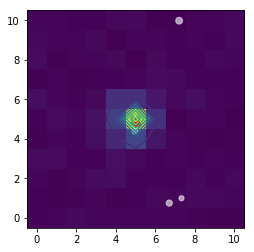

In [19]:
pmp1.info()


In [3]:
search_result = lk.search_targetpixelfile('TIC117070953')
tpf = search_result.download(quality_bitmask='default')

In [3]:
pmp1 = PixelMapPeriodogram(tpf, frequencies= [9.51112996, 19.02225993, 28.53338989, 38.04451986, 47.55564982, 57.06677979, 66.57790975, 76.08903972],frequnit=u.microHertz)

NameError: name 'PixelMapPeriodogram' is not defined

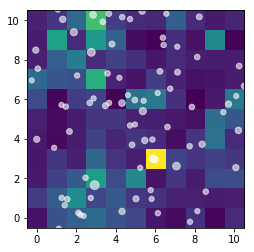

In [159]:
pmp1.info()


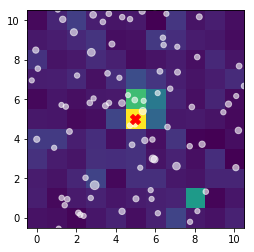

In [162]:
pmp1.info()

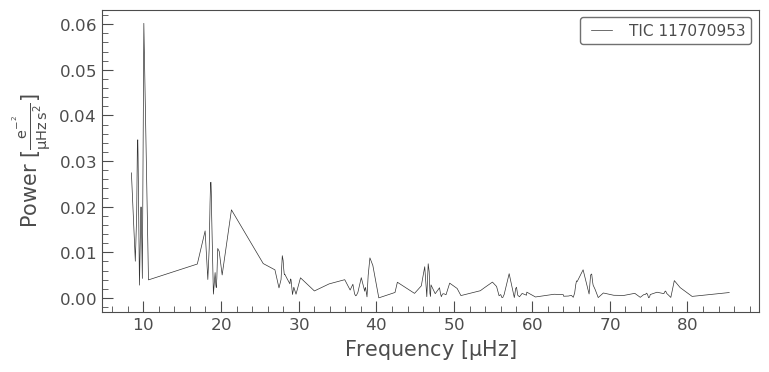

In [194]:
pmp1.periodogram[6][3].plot()

In [1]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from astropy import units as u
import scipy.optimize as opt
from photutils import centroids as cent
import lmfit as lm

In [4]:
frequency_list =  (np.asarray([9.51112996, 19.02225993, 28.53338989, 38.04451986, 47.55564982, 57.06677979, 66.57790975, 76.08903972,1000])*10**-6)*86400
flux = corrected_lc.flux
times = corrected_lc.time - np.mean(corrected_lc.time)
pg = corrected_lc.to_periodogram(frequency = frequency_list)
initial_flux= np.asarray(pg.power)

def lc_model(time,amp,freq,phase):
    return amp*np.sin(2*np.pi*freq*time + phase)
    
def background_model(time,height):
    return time*height/time

for i in np.arange(len(frequency_list)):
    
    if (i == 0):
        model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
        model += lm.Model(background_model, independent_vars=['time'])
    else:
        model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))
        
    
    model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value=0)
    model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i])
    model.set_param_hint('height', value= np.mean(flux))
    model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


NameError: name 'corrected_lc' is not defined

In [4]:
lightcurve = tpf.to_lightcurve(aperture_mask =tpf.pipeline_mask)
lc = lightcurve[np.where(lightcurve.quality == 0)]
lc = lc.remove_outliers()
lc = lc.flatten()

In [5]:
params = model.make_params()


NameError: name 'model' is not defined

In [12]:
# Make an aperture mask and a raw light curve
aper = tpf.create_threshold_mask()
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

# Make a design matrix and pass it to a linear regression corrector
dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(4).append_constant()
rc = lk.RegressionCorrector(raw_lc)
corrected_lc = rc.correct(dm)


In [15]:
plt.plot(tpf.time, dm.values + np.arange(4)*0.2, '.');

ValueError: operands could not be broadcast together with shapes (17749,5) (4,) 

In [6]:

result = model.fit(corrected_lc.flux,params,time=times)

In [10]:
result.best_values

{'f7amp': 8.574450022532757,
 'f7freq': 6.574093031808,
 'f7phase': -1.8100443366573684,
 'f6amp': 7.980579323441388,
 'f6freq': 5.7523314024,
 'f6phase': -1.0103634042302865,
 'f5amp': 9.974037098458556,
 'f5freq': 4.930569773855999,
 'f5phase': -0.4733759837409246,
 'f4amp': 9.39438398887992,
 'f4freq': 4.108808144448,
 'f4phase': 0.6211993452576094,
 'f3amp': 11.485223629818206,
 'f3freq': 3.287046515904,
 'f3phase': 1.2567943605372234,
 'f2amp': -11.010170919143055,
 'f2freq': 2.4652848864959997,
 'f2phase': -1.0092695536001584,
 'f1amp': -22.356435706927858,
 'f1freq': 1.643523257952,
 'f1phase': -0.07674206570930542,
 'height': 23278.81815914962,
 'f0amp': -13.267589794061111,
 'f0freq': 0.8217616285439999,
 'f0phase': 0.9616404766958846}

In [11]:
params['f0phase'].set(min=-np.pi,max=np.pi,brute_step=np.pi/10)

In [7]:
print(result.fit_report())

[[Model]]
    ((((((((Model(lc_model, prefix='f0') + Model(background_model)) + Model(lc_model, prefix='f1')) + Model(lc_model, prefix='f2')) + Model(lc_model, prefix='f3')) + Model(lc_model, prefix='f4')) + Model(lc_model, prefix='f5')) + Model(lc_model, prefix='f6')) + Model(lc_model, prefix='f7'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 166
    # data points      = 17749
    # variables        = 17
    chi-square         = 30878693.0
    reduced chi-square = 1741.41061
    Akaike info crit   = 132468.030
    Bayesian info crit = 132600.360
[[Variables]]
    f0amp:   -13.2675957 +/- 0.44266334 (3.34%) (init = 13.03151)
    f0freq:   0.8217616 (fixed)
    f0phase:  0.96164055 +/- 0.03344941 (3.48%) (init = 0)
    height:   23278.8181 +/- 0.31340998 (0.00%) (init = 23279.04)
    f1amp:   -22.3564291 +/- 0.44328516 (1.98%) (init = 22.14402)
    f1freq:   1.643523 (fixed)
    f1phase: -0.07673911 +/- 0.01982280 (25.83%) (init = 0)
    f2amp:   -11.010

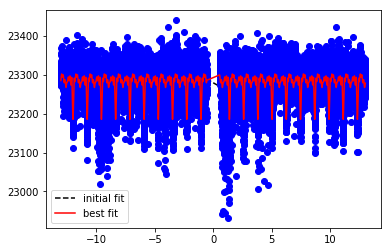

In [8]:

plt.plot(times, result.init_fit, 'k--', label='initial fit')
plt.plot(times, flux, 'bo')
plt.plot(times, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')




ValueError: x and y must have same first dimension, but have shapes (17749,) and (17729,)

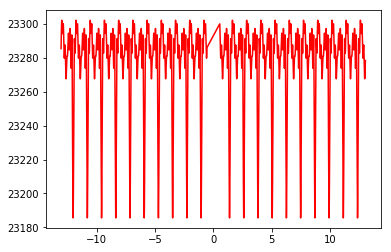

In [143]:
plt.plot(times, result.best_fit, 'r-', label='best fit')
plt.plot(times,bb.best_fit)
plt.xlim(-10,-2)


In [5]:
frequency_list =  (np.asarray([9.51112996, 19.02225993, 28.53338989, 38.04451986, 47.55564982, 57.06677979, 66.57790975, 76.08903972,1000])*10**-6)*86400

def Obtain_Initial_Phase(tpf,frequency_list):
    # Make an aperture mask and a raw light curve
    aper = tpf.create_threshold_mask()
    raw_lc = tpf.to_lightcurve(aperture_mask=aper)

    # Make a design matrix and pass it to a linear regression corrector
    dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
    rc = lk.RegressionCorrector(raw_lc)
    corrected_lc = rc.correct(dm)
    corrected_lc[np.where(corrected_lc.quality == 0)]
    corrected_lc = corrected_lc.remove_outliers()
    
    flux = corrected_lc.flux
    times = corrected_lc.time - np.mean(corrected_lc.time)
    pg = corrected_lc.to_periodogram(frequency = frequency_list)
    initial_flux= np.asarray(pg.power)
    
    initial_phase = np.zeros(len(frequency_list))
    
    def lc_model(time,amp,freq,phase):
        return amp*np.sin(2*np.pi*freq*time + phase)

    def background_model(time,height):
        return time*height/time
    for j in np.arange(len(frequency_list)):
        for i in np.arange(len(frequency_list)):

            if (i == 0):
                model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                model += lm.Model(background_model, independent_vars=['time'])
            else:
                model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


            model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phase[i],vary = False)
            model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=False)
            model.set_param_hint('height', value= np.mean(flux),vary=False)
            model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


        params = model.make_params()
        params['f{0:d}phase'.format(j)].set(vary=True)
        params['f{0:d}phase'.format(j)].set(value = initial_phase[j])
        params['f{0:d}phase'.format(j)].set(brute_step=np.pi/10)
        result = model.fit(corrected_lc.flux,params,time=times,method = 'brute')
        initial_phase[j]=result.best_values['f{0:d}phase'.format(j)]
    
    return initial_phase
    

In [6]:
initial_phases = Obtain_Initial_Phase(tpf,frequency_list)

The requested periodogram is not evenly sampled in frequency.
Method has been changed from 'fast' to 'slow' to allow for this.


In [7]:
def Obtain_Best_Fit(tpf,frequency_list,initial_phases):
    # Make an aperture mask and a raw light curve
    aper = tpf.create_threshold_mask()
    raw_lc = tpf.to_lightcurve(aperture_mask=aper)

    # Make a design matrix and pass it to a linear regression corrector
    dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
    rc = lk.RegressionCorrector(raw_lc)
    corrected_lc = rc.correct(dm)
    corrected_lc[np.where(corrected_lc.quality == 0)]
    corrected_lc = corrected_lc.remove_outliers()
    
    flux = corrected_lc.flux
    times = corrected_lc.time - np.mean(corrected_lc.time)
    pg = corrected_lc.to_periodogram(frequency = frequency_list)
    initial_flux= np.asarray(pg.power)
    
    
    def lc_model(time,amp,freq,phase):
        return amp*np.sin(2*np.pi*freq*time + phase)

    def background_model(time,height):
        return time*height/time

    for i in np.arange(len(frequency_list)):

        if (i == 0):
            model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
            model += lm.Model(background_model, independent_vars=['time'])
        else:
            model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


        model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phases[i],vary = True)
        model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
        model.set_param_hint('height', value= np.mean(flux),vary=True)
        model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


    params = model.make_params()

    result = model.fit(corrected_lc.flux,params,time=times)

    
    return result

In [140]:
bb = Obtain_Best_Fit(tpf,frequency_list,initial_phases)

In [141]:
bb

In [144]:
aper = tpf.create_threshold_mask()
ms = np.zeros((len(aper),len(aper[0])), dtype=bool)
ms[10][10]=True
raw_lc = tpf.to_lightcurve(aperture_mask=ms)



# Make a design matrix and pass it to a linear regression corrector
dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
rc = lk.RegressionCorrector(raw_lc)
corrected_lc = rc.correct(dm)
corrected_lc[np.where(corrected_lc.quality == 0)]
corrected_lc = corrected_lc.remove_outliers()

ValueError: array must not contain infs or NaNs

In [1]:
frequency_list = [9.51112996, 19.02225993, 28.53338989, 38.04451986, 47.55564982, 57.06677979, 66.57790975, 76.08903972]

In [295]:
frequency_list = [500.559, 506.057, 642.255, 740.266, 884.017, 889.556, 957.817, 963.28, 969.013, 1028.729, 1034.356, 1107.713, 1212.297, 1217.872, 1223.429]

# New Method

In [130]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from astropy import units as u
import scipy.optimize as opt
from photutils import centroids as cent
import lmfit as lm
from lmfit import Minimizer, Parameters, report_fit


class PixelMapFit:
    """Object to hold 2D array of lk.periodgram object data .
    Attributes
    ----------
    targetpixelfile : targetpixelfile object
        
    Optional keywords accepted if ``method='lombscargle'`` are:
            ``minimum_frequency``, ``maximum_frequency``, ``minimum_period``,
            ``maximum_period``, ``frequency``, ``period``, ``nterms``,
            ``nyquist_factor``, ``oversample_factor``, ``freq_unit``,
            ``normalization``, ``ls_method``.
        
    """
    
    def __init__(self, targetpixelfile, gaia=True, magnitude_limit=18, frequencies=[], frequnit=u.uHz, principle_components = 5, **kwargs):

        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        self.aperture = targetpixelfile.pipeline_mask
        self.tpf = targetpixelfile
    
        
        # Make a design matrix and pass it to a linear regression corrector
        self.raw_lc = self.tpf.to_lightcurve(aperture_mask=self.aperture)
        self.dm = lk.DesignMatrix(tpf.flux[:, ~targetpixelfile.create_threshold_mask()], name='regressors').pca(principle_components)
        rc = lk.RegressionCorrector(self.raw_lc)
        corrected_lc = rc.correct(self.dm.append_constant())
        corrected_lc[np.where(corrected_lc.quality == 0)]
        self.corrected_lc = corrected_lc.remove_outliers()
        self.frequency_list = np.asarray((frequencies*frequnit).to(1/u.d))
        self.principle_components = principle_components
        
        def Obtain_Initial_Phase(tpf,corrected_lc,frequency_list):

            flux = corrected_lc.flux
            times = corrected_lc.time - np.mean(corrected_lc.time)
            pg = corrected_lc.to_periodogram(frequency = frequency_list,ls_method='slow')
            initial_flux= np.asarray(pg.power)

            initial_phase = np.zeros(len(frequency_list))

            def lc_model(time,amp,freq,phase):
                return amp*np.sin(2*np.pi*freq*time + phase)

            def background_model(time,height):
                return time*height/time
            for j in np.arange(len(frequency_list)):
                for i in np.arange(len(frequency_list)):

                    if (i == 0):
                        model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                        model += lm.Model(background_model, independent_vars=['time'])
                    else:
                        model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


                    model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phase[i],vary = False)
                    model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=False)
                    model.set_param_hint('height', value= np.mean(flux),vary=False)
                    model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


                params = model.make_params()
                params['f{0:d}phase'.format(j)].set(vary=True)
                params['f{0:d}phase'.format(j)].set(value = initial_phase[j])
                params['f{0:d}phase'.format(j)].set(brute_step=np.pi/10)
                result = model.fit(corrected_lc.flux,params,time=times,method = 'brute')
                initial_phase[j]=result.best_values['f{0:d}phase'.format(j)]

            return initial_phase
        
        self.initial_phases = Obtain_Initial_Phase(self.tpf,self.corrected_lc,self.frequency_list)
        
        def Obtain_Final_Phase(tpf,corrected_lc,frequency_list,initial_phases):

            flux = corrected_lc.flux
            times = corrected_lc.time - np.mean(corrected_lc.time)
            pg = corrected_lc.to_periodogram(frequency = frequency_list)
            initial_flux= np.asarray(pg.power)


            def lc_model(time,amp,freq,phase):
                return amp*np.sin(2*np.pi*freq*time + phase)

            def background_model(time,height):
                return time*height/time

            for i in np.arange(len(frequency_list)):

                if (i == 0):
                    model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                    model += lm.Model(background_model, independent_vars=['time'])
                else:
                    model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


                model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phases[i],vary = True)
                model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
                model.set_param_hint('height', value= np.mean(flux),vary=True)
                model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


            params = model.make_params()

            result = model.fit(corrected_lc.flux,params,time=times)
            
            final_phases = [result.best_values['f{0:d}phase'.format(j)] for j in np.arange(len(frequency_list))]

    
            return final_phases

        self.final_phases = Obtain_Final_Phase(self.tpf,self.corrected_lc,self.frequency_list,self.initial_phases)
    
        def Obtain_Final_Fit(tpf,corrected_lc,frequency_list,final_phases):

            flux = corrected_lc.flux
            times = corrected_lc.time - np.mean(corrected_lc.time)
            pg = corrected_lc.to_periodogram(frequency = frequency_list)
            initial_flux= np.asarray(pg.power)


            def lc_model(time,amp,freq,phase):
                return amp*np.sin(2*np.pi*freq*time + phase)

            def background_model(time,height):
                return time*height/time

            for i in np.arange(len(frequency_list)):

                if (i == 0):
                    model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                    model += lm.Model(background_model, independent_vars=['time'])
                else:
                    model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


                model.set_param_hint('f{0:d}phase'.format(i), value= final_phases[i],vary = False)
                model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
                model.set_param_hint('height', value= np.mean(flux),vary=True)
                model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


            params = model.make_params()

            result = model.fit(corrected_lc.flux,params,time=times)
            
            return result
        
        
        heats = []
        heats_error =[]
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rows of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = self.tpf.to_lightcurve(aperture_mask=mask)
                rcc = lk.RegressionCorrector(lightcurve)
                lc = rcc.correct(self.dm.append_constant())
                #lc = lc[np.where(lc.quality == 0)]
                #lc = lc.remove_outliers()

                
                
                
                bestfit = Obtain_Final_Fit(self.tpf,lc,self.frequency_list,self.final_phases)
                heat = np.asarray([bestfit.best_values['f{0:d}amp'.format(n)] for n in np.arange(len(self.frequency_list))])
                #heat = bestfit.best_values['f0amp']# / bestfit.params['f0amp'].stderr
                heat_error =  np.asarray([bestfit.params['f{0:d}amp'.format(n)].stderr for n in np.arange(len(self.frequency_list))])
                
                #Extending the list of fitting data for each pixel
                heats.extend([heat])
                heats_error.extend([heat_error])
                
        #Taking the final list and turning it into a 2-d numpy array with the same dimensions of the full postage stamp      
        #heats = np.reshape(np.asarray(heats),(len(self.aperture),len(self.aperture[0])))
        #heats_error = np.reshape(np.asarray(heats_error),(len(self.aperture),len(self.aperture[0])))
        heats = np.asarray(heats)
        heats_error = np.asarray(heats_error)
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.heatmap = heats.T
        self.heatmap_error = heats_error.T
        self.timeserieslength = (self.tpf.astropy_time.max()-self.tpf.astropy_time.min()).value
        self.gaiadata = None
        
        if (gaia == True):
            """Make the Gaia Figure Elements"""
            # Get the positions of the Gaia sources
            c1 = SkyCoord(self.tpf.ra, self.tpf.dec, frame='icrs', unit='deg')
            # Use pixel scale for query size
            pix_scale = 4.0  # arcseconds / pixel for Kepler, default
            if self.tpf.mission == 'TESS':
                pix_scale = 21.0
            # We are querying with a diameter as the radius, overfilling by 2x.
            from astroquery.vizier import Vizier
            Vizier.ROW_LIMIT = -1
            result = Vizier.query_region(c1, catalog=["I/345/gaia2"],radius=Angle(np.max(self.tpf.shape[1:]) * pix_scale, "arcsec"))

            no_targets_found_message = ValueError('Either no sources were found in the query region '
                                                      'or Vizier is unavailable')
            too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
            if result is None:
                raise no_targets_found_message
            elif len(result) == 0:
                raise too_few_found_message
            result = result["I/345/gaia2"].to_pandas()

            result = result[result.Gmag < magnitude_limit]
            if len(result) == 0:
                raise no_targets_found_message

            year = ((self.tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
            pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            result.RA_ICRS += pmra
            result.DE_ICRS += pmdec
            radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
            coords = tpf.wcs.all_world2pix(radecs, 0) 



            # Gently size the points by their Gaia magnitude
            sizes = 64.0 / 2**(result['Gmag']/5.0)
            one_over_parallax = 1.0 / (result['Plx']/1000.)
            source = dict(ra=result['RA_ICRS'],
                          dec=result['DE_ICRS'],
                          source=result['Source'].astype(str),
                          Gmag=result['Gmag'],
                          plx=result['Plx'],
                          one_over_plx=one_over_parallax,
                          x=coords[:, 0],
                          y=coords[:, 1],
                          size=sizes)


            self.gaiadata = source
        class frequency_heatmap:

            def __init__(self,tpf,heats,heats_error,frequencies,gaia_data):
                self.heat_stamp = heats
                self.gaiadata=gaia_data
                self.heatmap_error = heats_error
                self.size = tpf.pipeline_mask.shape
                self.frequencies= frequencies
            def centroid(self):
                
                #Residuals to minimize relative to the error bars
                def residual(params, amp, amperr):
                    
                    x = params['x']
                    y = params['y']
                    sigma = params['sigma']

                    xpix,ypix = np.meshgrid(np.arange(self.size[0]),np.arange(self.size[1]))
                    
                    res = []
                    for i in np.arange(len(self.frequencies)):
                        height = params['height{0:d}'.format(i)]
                        
                        model = height*np.exp(-(((x-xpix)/sigma)**2+((y-ypix)/sigma)**2)/2)
                        
                        res.extend( [(amp[i].reshape(self.size)-model) / amperr[i].reshape(self.size)])
                        

                    return np.asarray(res)

                #Set starting values to converge from
                c = cent.centroid_2dg(self.heat_stamp.sum(axis=0).reshape(self.size) / np.sqrt((self.heatmap_error**2).sum(axis=0)).reshape(self.size))
                params = Parameters()
                for i in np.arange(len(frequencies)):
                    params.add('height{0:d}'.format(i), value=np.max(self.heat_stamp[i]))
                params.add('x', value=c[0]) 
                params.add('y', value=c[1])
                params.add('sigma', value=1)
                
                #Do the fit
                minner = Minimizer(residual, params, fcn_args=(self.heat_stamp, self.heatmap_error))
                self.result = minner.minimize()
                fit = self.result.params.valuesdict()
                self.x = fit['x']
                self.y = fit['y']

                
            def star_list(self):
                gaia_data = self.gaiadata
                no_gaia_data_message = ValueError('No gaia data initialized in PixelMapPeriodogram class')
                if gaia_data ==None :
                    raise no_gaia_data_message

                else:    
                    closest_star_mask = np.where(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])==(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])).min())
                    stars = dict(ra = np.asarray(gaia_data['ra']),
                                 dec = np.asarray(gaia_data['dec']),
                                 source = np.asarray(gaia_data['source']),
                                 x = np.asarray(gaia_data['x']),
                                 y = np.asarray(gaia_data['y']),
                                 distance = np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y']))
                    starlist = pd.DataFrame.from_dict(stars)
                    self.stars = starlist.sort_values(by=[r'distance'])
                    
        fh = frequency_heatmap(self.tpf,self.heatmap,self.heatmap_error,self.frequency_list,self.gaiadata) 
        fh.centroid()
        fh.star_list()
        self.centroid = [fh.x,fh.y]
        self.heatmap = self.heatmap.sum(axis=0).reshape(self.aperture.shape[0],self.aperture.shape[1]) / np.sqrt((self.heatmap_error**2).sum(axis=0)).reshape(self.aperture.shape[0],self.aperture.shape[1])
        self.starfit= fh.stars.reset_index()
        self.result = fh.result
    
    def info(self):
        plt.imshow(self.heatmap,origin=0)
        #plot the centroid
        if (self.gaiadata != None):
            plt.scatter(self.gaiadata['x'],self.gaiadata['y'],s=self.gaiadata['size']*5,c='white',alpha=.6)
            plt.scatter(self.centroid[0],self.centroid[1],marker='X',s=100)
            plt.scatter(self.gaiadata['x'][3],self.gaiadata['y'][3],s=self.gaiadata['size']*5,c='red',alpha=1)
        plt.xlim(-.5,self.aperture.shape[1]-1+.5)
        plt.ylim(-.5,self.aperture.shape[0]-1+.5)
        print(self.starfit)
        report_fit(self.result)
    
    def pca(self):
        plt.figure(figsize=(12,5))
        plt.plot(self.tpf.time, self.dm.values + np.arange(self.principle_components)*0.2)
        plt.title('Principle Components Contributions')
        plt.xlabel('Offset')
        g2 = self.raw_lc.plot(label='Raw light curve')
        self.corrected_lc.plot(ax=g2, label='Corrected light curve')

        plt.show()
                
        
        



In [132]:
test = PixelMapFit(tpf,frequencies=frequency_list)

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains d

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains d

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains d

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains d

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains d

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)
C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\correctors\designmatrix.py:244: LightkurveWarning: The design matrix has low rank (6) compared to the number of columns (6), which suggests that the matrix contains d

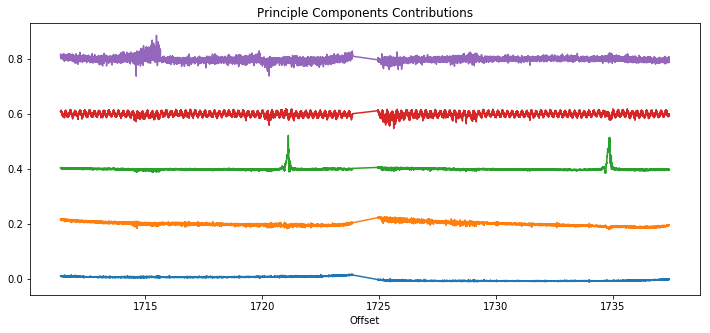

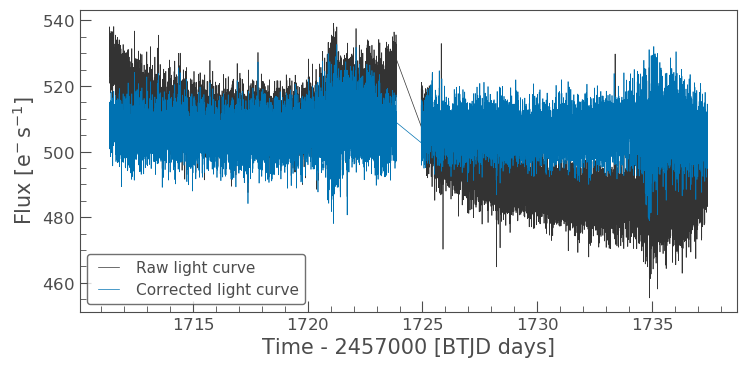

In [104]:
test.pca()

     index          ra        dec               source          x          y  \
0       89  319.294964  34.196133  1855294415817908480   5.876951   2.998218   
1       92  319.295630  34.196130  1855294415817907840   5.961744   2.957995   
2       75  319.292226  34.192087  1855294312738692480   5.237045   2.537803   
3       98  319.291908  34.201217  1855294415817910144   5.852838   3.964698   
4       86  319.289577  34.200021  1855294312738695296   5.469589   3.919459   
..     ...         ...        ...                  ...        ...        ...   
219    187  319.258799  34.263911  1855295545386531840   6.141734  15.608942   
220    208  319.289020  34.270607  1855295893286678272  10.473577  14.837415   
221    223  319.241740  34.258541  1867305137241296768   3.582052  15.799980   
222    219  319.216185  34.237633  1867304999802343552  -1.178783  14.104036   
223    185  319.256403  34.267368  1855295549689299840   6.085194  16.285082   

       distance  
0      0.006280  
1  

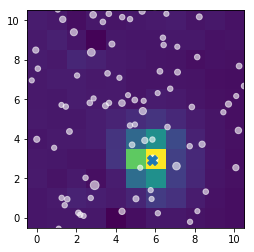

In [133]:
test.info()


Include the tools used to motivate our paper, don't include in package.
Make notebook for figures made for paper.

include error bars on fit
